In [82]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import circmean, circvar
from matplotlib.animation import FuncAnimation

import seaborn as sns

from matplotlib import rc
import yaml
import os

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5') # conda create -n newenv -c conda-forge ffmpeg

with open("cal-settings.yml", 'r') as file:
    vars = yaml.safe_load(file)
    RX_TX_SAME_CHANNEL = vars["RX_TX_SAME_CHANNEL"]

print("Cable connections")
if RX_TX_SAME_CHANNEL:
    REF_RX_CH = FREE_TX_CH = 0
    LOOPBACK_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH0 RX\nCH1 TX-->CH1 RX\nCH0 TX -->")
else:
    LOOPBACK_RX_CH = FREE_TX_CH = 0
    REF_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH1 RX\nCH1 TX-->CH0 RX\nCH0 TX -->")

ref_rx = f"rx_ch{REF_RX_CH}"

Cable connections

PLL REF-->CH1 RX
CH1 TX-->CH0 RX
CH0 TX -->


In [83]:
# MEAS 1
usrp_files = [f'data_T01_20240531140905.txt', f'data_T04_20240531140912.txt']


# MEAS 2
# samples[int(RATE//10):-int(RATE//10)] removed also the last portion of the sampled data
usrp_files = [f'data_T01_20240531142908.txt', f'data_T04_20240531142909.txt']

# MEAS 3 20 second capture time
usrp_files = [f'data_T01_20240531145422.txt', f'data_T04_20240531145425.txt']


# MEAS 4 changed circmean to median 
usrp_files = [f'data_T01_20240601194031.txt', f'data_T04_20240601194029.txt']


# MEAS 5 with new 10MHz from external signal generator and splitter
usrp_files = [f'data_T04_20240610094551.txt', f'data_T01_20240610094550.txt']


# MEAS 5 with new 10MHz from external signal generator and splitter + stored more data: TX_ANGLE_CH0 ; TX_ANGLE_CH1 ; RX_ANGLE_CH0 ; RX_ANGLE_CH1 ; RX_AMPL_CH0 ; RX_AMPL_CH1 ; RX_ANGLE_VAR_CH0 ; RX_ANGLE_VAR_CH1 ; RX_AMPL_VAR_CH0 ; RX_AMPL_VAR_CH1
usrp_files = [f'data_T04_20240610112937.txt',
              f'data_T01_20240610112942.txt']

In [84]:
# wrap around function which "glues" together 0 and 360 degrees.

def wraparound(arr, do=True):
    if not do:
        return arr
    arr = np.asarray(arr)
    fltr = arr > 180
    arr[fltr] = arr[fltr] - 360
    return arr

In [85]:
fields = ["meas_id", "hostname", "meas_type",
          "tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1", "rx_ampl_ch0", "rx_ampl_ch1", "rx_var_ch0", "rx_var_ch1", "rx_ampl_var_ch0", "rx_ampl_var_ch1",]


dfs = [pd.read_csv(file,
                  names=fields, header=None, sep=';') for file in usrp_files]


# given that we meanly want to plot things, shift the radians to degrees and wrap around
fltr_pll = [None]*len(usrp_files)
for i, df in enumerate(dfs):
    for col in ["tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1"]:
        df.loc[:, col] = wraparound(np.rad2deg(df[col]), False)
    fltr_pll[i] = df['meas_type'] == "PLL"
    # df.drop(columns=["_0", "_1"], inplace=True)

    

Check the absolute measured loopback check per USRP. This means read the measured phase after the first phase calibration (i.e., transmitting with $-(\phi_{rx}+\phi_{tx})$).

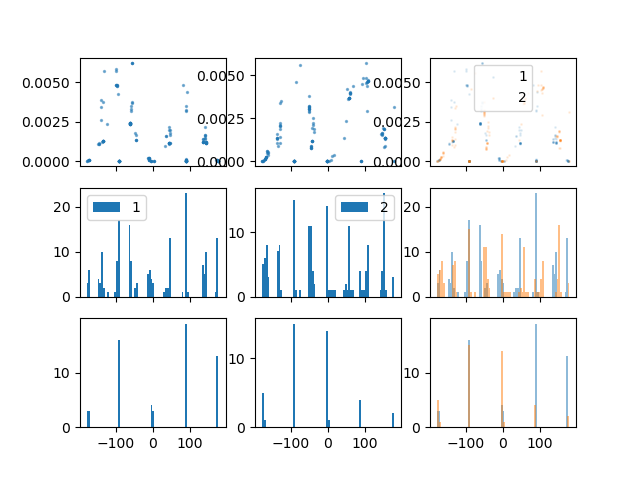

In [86]:
fig, axes = plt.subplots(nrows=3, ncols=len(usrp_files)+1, sharex=True)

if np.asarray(axes).ndim == 1:
    axes = np.atleast_2d(axes).transpose()

resolution = 5


for i, df in enumerate(dfs):

    x_df = dfs[i].where(fltr_pll[i]).loc[:, ref_rx].values
    y_df  = dfs[i].where(fltr_pll[i]).loc[:, f"rx_var_ch{REF_RX_CH}"].values 

    # spread them random over [0,1.0)

    axes[0, i].scatter(x_df, y_df, s=2, alpha=0.5, label=i+1);

    axes[0, -1].scatter(x_df, y_df, s=1, alpha=0.1, label=i+1);

    axes[1, i].hist(x_df, bins=360//resolution, label=i+1);

    axes[1, -1].hist(x_df, bins=360 //
                     resolution, label=i+1, alpha=0.5)

    axes[2, i].hist(x_df[y_df < 0.0001], bins=360//resolution, label=i+1)

    axes[2, -1].hist(x_df[y_df < 0.0001], bins=360 //
                     resolution, label=i+1, alpha=0.5)


    axes[1, i].legend();
axes[0, -1].legend();

Remove center of each cluster and combine dist

c:\Users\Calle\radioconda\envs\NEWENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


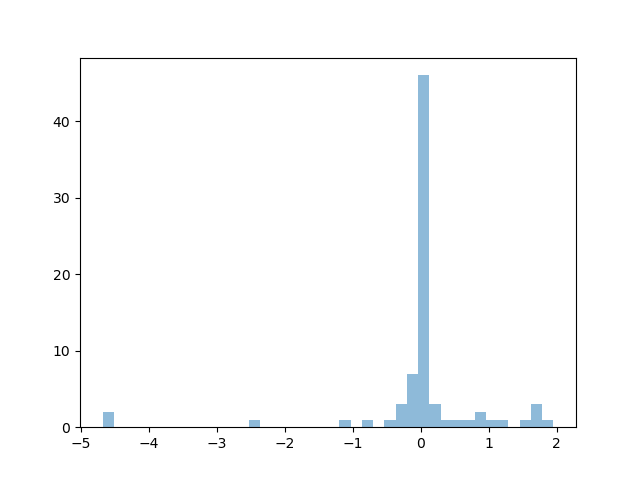

c:\Users\Calle\radioconda\envs\NEWENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


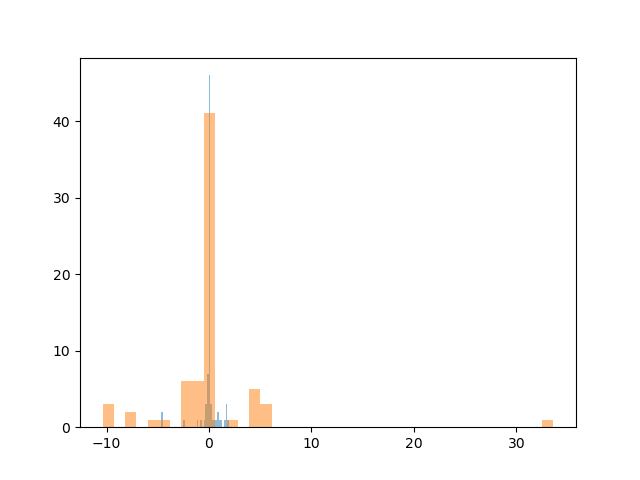

In [87]:
from sklearn.cluster import KMeans
num_clusters = 8

plt.figure()
for i, df in enumerate(dfs):
    x_df = dfs[i].where(fltr_pll[i]).loc[:, ref_rx].values
    y_df = dfs[i].where(fltr_pll[i]).loc[:, f"rx_var_ch{REF_RX_CH}"].values

    x_df = x_df[y_df < 0.001]

    # Reshape array for KMeans
    data = x_df.reshape(-1, 1)

    # Apply KMeans with 8 clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(data)

    # Get the cluster labels
    labels = kmeans.labels_

    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Remove the center value of the cluster for each sample
    adjusted_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        center = cluster_centers[labels[i]]
        adjusted_data[i] = data[i] - center

    # Flatten the adjusted data back to 1D
    adjusted_data = adjusted_data.flatten()

    plt.hist(adjusted_data, bins=40, alpha=0.5)
    plt.show()